# Reservoir Dynamics
$t$ is understood to be a discrete time step. 

Suppose a signal $\mathbf{u}(t) \in \reals^D$. 

Suppose a reservoir state $\mathbf{r}(t) \in \reals^R$. We also require that 
$d | N$. 

The initial reservoir state is 
$$
    \mathbf{r}(0) = W_{\text{in}} \mathbf{u}(0).
$$

The reservoir dynamics in the training stage are:
$$
    \mathbf{r}(t+1) = (1 - \alpha) \mathbf{r}(t) + \alpha \tanh(A \mathbf{r}(t) + W_{\text{in}} \mathbf{u}(t))
$$
where the hyperparameter $\alpha$ is known as the leakage rate. Set $\alpha = 1$
to reduce the number of hyperparameters that need to be optimised. 

# Reservoir Internals
### Adjacency matrix ($A$)
$A$ is known as the **internal connection network**, also the rotation matrix,
or adjacency matrix. Describes which nodes at a particular state of the 
reservoir will communicate with each other. 

$A$ has shape $R \times R$. Initialise $A$ with zeros.  

$A$ is also required to be sparse. We define sparseness as the degree each node 
in the network. Let $k$ denote the sparseness. Then we fix the in-degree of 
each node to be exactly $k$. That is, if the $(i, j)$-th element of $A$ 
represents the weight of the edge going from node $j$ into node $i$, then we 
uniformly and randomly choose $k$ positions without replacement in each row to have the value one. 
Again, to avoid increasing the number of hyperparameters, we use 
$k = \text{int}(0.05 \times R)$, where recall $N$ is the number of nodes in the 
reservoir. 

The nonzero elements of $A$ are then scaled Uniform(0, 1). Then $A$ is scaled so that 
its spectral radius is less than or equal to $\rho$. Spectral radius is defined 
as the largest absolute eigenvalue. This quantity is also the spectral radius 
of the reservoir. 

Now it is very likely for $A$ to satisfy the echo state property. 

### External input connection matrix ($W_{\text{in}}$)
$W_{\text{in}}$ is known as the **external input connection network**. Describes 
which parts of the input signal will be connected to the current reservoir state. 

$W_{\text{in}}$ has shape $R \times D$. 

$W_{\text{in}}$ is initiated with all zeros. Draw a random permutation of the 
integers $1,\dots,R$. Divide this permutation in order into $\frac{R}{D}$ 
groups, each of size $D$. For group $i$, $i = 1,\dots,\frac{R}{D}$, fill in 
column $i$ of $W_{\text{in}}$ with 1's in the positions described in group 
$i$. 

For example, suppose $R = 6$ and $D = 3$, and a permutation is $142536$. Clearly 
the groups, in order, are $\{1, 4\}$, $\{2, 5\}$, $\{3, 6\}$. Then form 
$W_{\text{in}}$ as:
$$
\begin{bmatrix}
1 &0 &0 \\
0 &1 &0 \\
0 &0 &1 \\
1 &0 &0 \\
0 &1 &0 \\
0 &0 &1
\end{bmatrix}
$$
Because $D | R$, we should only have one nonzero element in each row, and 
exactly $\frac{R}{D}$ nonelements in each column. This represents the idea that 
every network receives exactly one scalar input from $\mathbf{u}(t)$, while 
each scalar input $\mathbf{u}(t)$ is connected to exactly $\frac{R}{R}$ nodes 
in the network. 

Finally, scale the nonzero elements of $W_{\text{in}}$ by a weight chosen 
randomly from Uniform(-$\sigma$, $\sigma$). 


# Summary of Hyperparameters
- $\alpha$, the leakage rate. Set to $\alpha = 1$ for project. 
- 

In [1]:
import numpy as np
import pandas as pd
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = "white"

from data import data, acf
from reservoir import reservoir as res
from error import error

In [2]:
hyperparams = {
    "RHO": 0.6,
    "SIGMA": 1.0,
    "R": 600,
    "EPSILON": 10e-4
}
state = np.random.RandomState(42)

In [3]:
training_data = data.generate_lorenz_63()

training_res, A, W_in = res.generate_training_reservoir(
    u=training_data,
    hyperparams=hyperparams,
    state=state
)

In [4]:
training_res

array([[-2.19025937, -3.40219631,  4.36641489, ...,  2.84875478,
        20.63237162, -3.0940225 ],
       [-0.97290032, -0.98408632,  0.99991442, ...,  0.9995366 ,
         1.        , -0.99628846],
       [-0.96363235, -0.99635355,  0.99961426, ...,  0.99793261,
         1.        , -0.99852899],
       ...,
       [-0.99199566,  0.99999999, -1.        , ..., -1.        ,
         1.        ,  1.        ],
       [-0.99495329,  0.99999999, -1.        , ..., -1.        ,
         1.        ,  1.        ],
       [-0.99651776,  0.99999999, -1.        , ..., -0.99999999,
         1.        ,  1.        ]])

In [5]:
W_out = res.generate_W_out(training_data, training_res, hyperparams)

In [6]:
def output_node(W_out, node):
    return np.dot(W_out, node)

def output_series(W_out, res):
    n = res.shape[0]
    D = W_out.shape[0]
    preds = np.zeros((n, D))
    for i in range(n):
        preds[i] = output_node(W_out, res[i])

    return preds

In [7]:
preds = output_series(W_out, training_res)

In [8]:
preds

array([[-4.79865602, -3.8777624 , 24.22291497],
       [-4.6606653 , -4.19610269, 23.33468524],
       [-4.61035368, -4.57079015, 22.4972438 ],
       ...,
       [13.43836183, 16.2705772 , 30.31862423],
       [13.84886619, 14.94951678, 32.90761273],
       [13.87765481, 12.97589875, 34.96739224]])

In [9]:
training_data

array([[-4.79865193, -3.87775884, 24.22289184],
       [-4.66044538, -4.19640537, 23.33475869],
       [-4.61119757, -4.57935812, 22.51723171],
       ...,
       [13.38843314, 16.23068466, 30.28483274],
       [13.79316077, 14.93328438, 32.86134879],
       [13.82727652, 13.00365668, 34.93243311]])

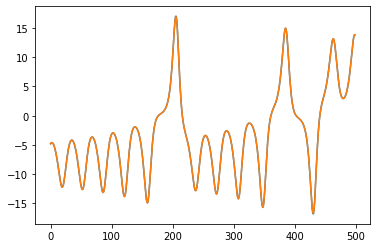

In [10]:
plt.plot(training_data[:, 0])
plt.plot(preds[:, 0])

In [11]:
error.RMSE(training_data, preds)

array([0.01859544, 0.02608332, 0.03412419])

In [12]:
forecast_data = data.generate_lorenz_63(initial_state=[2,2,2])
forecast_res = res.generate_forecast_res(
    r_0=training_res[-1],
    u=forecast_data,
    hyperparams=hyperparams,
    A=A,
    W_in=W_in,
    W_out=W_out
)
forecast_preds = res.output_series(W_out, forecast_res)

In [13]:
forecast_data

array([[-11.02689059,  -4.38007632,  36.52715775],
       [ -9.6519937 ,  -2.65874059,  35.33147914],
       [ -8.26092869,  -1.43111617,  33.84632604],
       ...,
       [-14.20046436,  -6.67932315,  41.01818336],
       [-12.49709781,  -3.18371304,  40.16098875],
       [-10.54400848,  -0.5177164 ,  38.47810159]])

In [14]:
forecast_preds

array([[13.87765481, 12.97589875, 34.96739224],
       [21.6988608 , 16.38642059, 42.75873563],
       [27.67944451, 25.69345121, 36.2408601 ],
       ...,
       [32.77023474, 46.11541926, 33.40338963],
       [32.77023474, 46.11541926, 33.40338963],
       [32.77023474, 46.11541926, 33.40338963]])

In [15]:
print(error.RMSE(forecast_data, forecast_preds))
print(max(error.RMSE(forecast_data, forecast_preds)))
print(np.linalg.norm(error.RMSE(forecast_data, forecast_preds)))

[32.08975475 45.27871026 13.50039529]
45.2787102567945
57.115450057050424


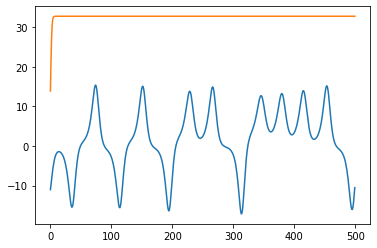

In [16]:
plt.plot(forecast_data[:, 0])
plt.plot(forecast_preds[:, 0])


In [17]:
hyperparams = {
    "RHO": 0.6,
    "SIGMA": 1.0,
    "R": 300,
    "EPSILON": 10e-4
}
RHO_RANGE = np.linspace(0.1, 0.7)
SIGMA_RANGE = np.linspace(0.5, 1.5)
R_RANGE = range(300, 900, 3)
EPSILON_RANGE = [0.01, 0.02]

def find_start_and_end(range):
    return range[0], range[-1]
def generate_search_space(rho_range=RHO_RANGE, sigma_range=SIGMA_RANGE, R_range=R_RANGE, epsilon_range=EPSILON_RANGE) -> list:
    rho_start, rho_end = find_start_and_end(rho_range)
    sigma_start, sigma_end = find_start_and_end(sigma_range)
    # epsilon_start, epsilon_end = find_start_and_end(epsilon_range)

    return [
        hp.uniform('rho', rho_start, rho_end),
        hp.uniform('sigma', sigma_start, sigma_end)
        # hp.choice('R', options=list(R_range)),
        # hp.uniform('epsilon', epsilon_start, epsilon_end)
    ]

 50%|█████     | 50/100 [00:15<00:15,  3.17trial/s, best loss: 16.809407002390223]


KeyboardInterrupt: 

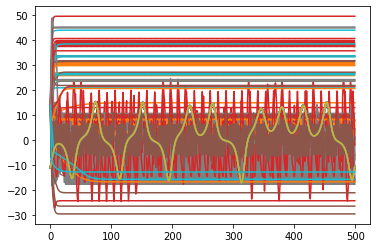

In [20]:
def objective(hyperparams: list) -> float:
    hyperparams = {
        "RHO": hyperparams[0],
        "SIGMA": hyperparams[1],
    }

    hyperparams["R"] = 300
    hyperparams["EPSILON"] = 10e-4
    
    # training reservoir
    training_res, A, W_in = res.generate_training_reservoir(
        u=training_data,
        hyperparams=hyperparams,
        state=state
    )
    
    # W_out
    W_out = res.generate_W_out(training_data, training_res, hyperparams)


    forecast_res = res.generate_forecast_res(
        r_0=training_res[-1],
        u=forecast_data,
        hyperparams=hyperparams,
        A=A,
        W_in=W_in,
        W_out=W_out
    )

    preds = res.output_series(W_out, forecast_res)

    return np.linalg.norm(error.RMSE(forecast_data, preds))

best = fmin(
    fn=objective,
    space=generate_search_space(),
    algo=tpe.suggest,
    max_evals=100
)
print(best)